# ¿Es realmente el chicharrón bueno para la salud? Modelos de ML y redes neuronales para detectar noticias falsas en el contexto colombiano. Pt 2.

# Índice

1. Importación de librerías
2. Importación de los datasets y creación de los conjuntos de entrenamiento, test y validación
3. Importación del modelo BERT en español, tokenización y construcción de tensores y dataloaders
4. Arquitectura de la red neuronal
5. Creación de funciónes de entrenamiento y de evaluación 
6. Visualización de los resultados
7. Evaluación del modelo 
8. Evaluación del mejor modelo con noticias nuevas
9. Conclusiones
 
 Nota

# 1. Importación de librerías

In [92]:
#instalamos transformers y pycaret
! pip install transformers
! pip install pycaret

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pycaret
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
import seaborn as sns 
import torch.nn.functional as F

# specify GPU  (as I don't have GPU I specify the CPU instead)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [170]:
#configuración notebook
pd.set_option('display.max_colwidth', None)

In [94]:
#comprobación de GPU

if torch.cuda.is_available():
    # Obtén el número de GPUs disponibles
    num_gpus = torch.cuda.device_count()
    
    # Muestra información sobre cada GPU
    for i in range(num_gpus):
        gpu_name = torch.cuda.get_device_name(i)
        print(f"GPU {i + 1}: {gpu_name}")
else:
    print("No se detectaron GPUs disponibles.")

No se detectaron GPUs disponibles.


In [95]:
#definir e imprimir la ruta actual del notebook y de los archivos que se importaran y se descargaran 

import os
os.chdir('/Users/juanviatela/Google Drive (juanviatela@gmail.com)/Notebooks/Proyecto Final')
current_directory = os.getcwd()
print("La ruta actual es:", current_directory)

La ruta actual es: /Users/juanviatela/Google Drive (juanviatela@gmail.com)/Notebooks/Proyecto Final


# 2. Importación de los datasets y creación de los conjuntos de entrenamiento, test y validación

In [96]:
#importamos los datasets
df_fakenews_2022 = pd.read_excel('Corpus_Noticias_2022.xlsx')
df_fakenews_2023 = pd.read_excel('Corpus_Noticias_2023.xlsx')

In [147]:
#concatenamos los datasets
df_news_concat = pd.concat([df_fakenews_2022, df_fakenews_2023], ignore_index=True)

In [98]:
#codificamos los labels
category_codes = {
     'Noticia Real': 0,
     'Noticia Falsa': 1
}

#creamos una nueva columna 'label' con las etiquetas. 0 para noticia real, 1 para noticia falsa. 
df_news_concat['label'] = df_news_concat['Categoria']
df_news_concat = df_news_concat.replace({'label':category_codes})

In [99]:
df_news_concat.head(5)

,ID,Categoria,Tema,Origen,Titulo,Texto,Fuente,label
0,1,Noticia Real,Politico,El tiempo,Duque dice que Eln se adjudicó atentado y busc...,El presidente Iván Duque condenó fuertemente e...,https://www.eltiempo.com/politica/gobierno/eln...,0
1,2,Noticia Real,Politico,El espectador,"Gustavo Petro se reunirá con Pedro Sánchez, pr...","Gustavo Petro se reunirá con Pedro Sánchez, pr...",https://www.elespectador.com/politica/?utm_sou...,0
2,3,Noticia Real,Politico,El tiempo,Marta Lucía Ramírez se queja por servicio en e...,Marta Lucía Ramírez se queja por servicio en e...,https://www.eltiempo.com/politica/gobierno/mar...,0
3,4,Noticia Real,Politico,El espectador,"Elecciones de 2022 requieren mayor cuidado, po...","Elecciones de 2022 requieren mayor cuidado, po...",https://www.elespectador.com/politica/eleccion...,0
4,5,Noticia Real,Politico,El Nuevo Siglo,Procuraduría citó a mandatarios por fiestas en...,ANTE LA expansión de la variante ómicron en el...,https://www.elnuevosiglo.com.co/articulos/01-0...,0


In [100]:
check_labels = df_news_concat[['Categoria', 'Texto', 'label']]
check_labels

,Categoria,Texto,label
0,Noticia Real,El presidente Iván Duque condenó fuertemente e...,0
1,Noticia Real,"Gustavo Petro se reunirá con Pedro Sánchez, pr...",0
2,Noticia Real,Marta Lucía Ramírez se queja por servicio en e...,0
3,Noticia Real,"Elecciones de 2022 requieren mayor cuidado, po...",0
4,Noticia Real,ANTE LA expansión de la variante ómicron en el...,0
...,...,...,...
1443,Noticia Falsa,"Esta imagen me dejó marcado, yo la recuerdo y ...",1
1444,Noticia Falsa,En Alemania el gobierno subió el precio del co...,1
1445,Noticia Falsa,Gustavo Petro es un demonio que le ha dado el ...,1
1446,Noticia Falsa,Alias 19 será el nuevo comandante del Esmad no...,1


([<matplotlib.patches.Wedge at 0x7fda20be6ce0>,
 [Text(-1.2000000000000002, 1.469576158976824e-16, 'Fake'),
  Text(1.2000000000000002, -2.939152317953648e-16, 'True')],
 [Text(-0.7, 8.572527594031472e-17, '50.0%'),
  Text(0.7, -1.7145055188062944e-16, '50.0%')])

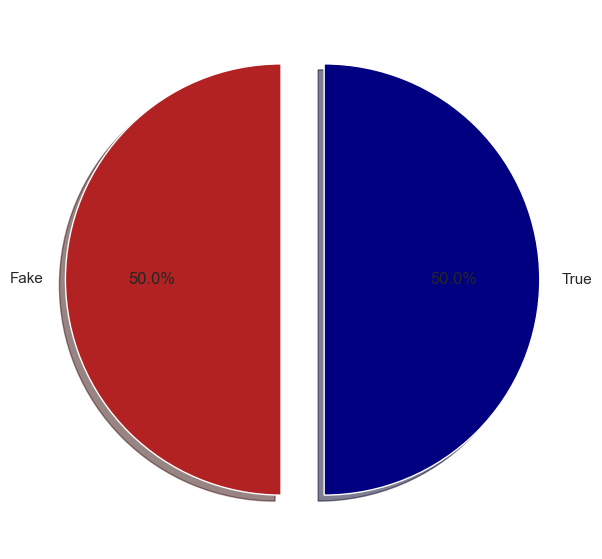

In [101]:
#comprobamos si 'label' está balanceada
label_size = [df_news_concat['label'].sum(),len(df_news_concat['label'])-df_news_concat['label'].sum()]
plt.pie(label_size,explode=[0.1,0.1],colors=['firebrick','navy'],startangle=90,shadow=True,labels=['Fake','True'],autopct='%1.1f%%')

In [102]:
#establecemos el valor de la semilla
SEED = 42

#creamos conjuntos de entrenamiento, validación y test (70:15:15)

#creamos el conjunto train y el conjunto temp
train_text, temp_text, train_labels, temp_labels = train_test_split(df_news_concat['Texto'], df_news_concat['label'], 
                                                                    random_state=SEED, 
                                                                    test_size=0.3, stratify=df_news_concat['Categoria'] 
                                                                    )
# Creamos el conjunto de validación sobre el conjunto 'temp'
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=SEED, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

# 3. Importación del modelo BERT en español, tokenización y construcción de tensores y dataloaders

In [103]:
#cargamos el modelo BETO y su tokenizer desde HuggingFace Transformers
beto = AutoModel.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')
tokenizer = BertTokenizerFast.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bi

Text(0, 0.5, 'Number of texts')

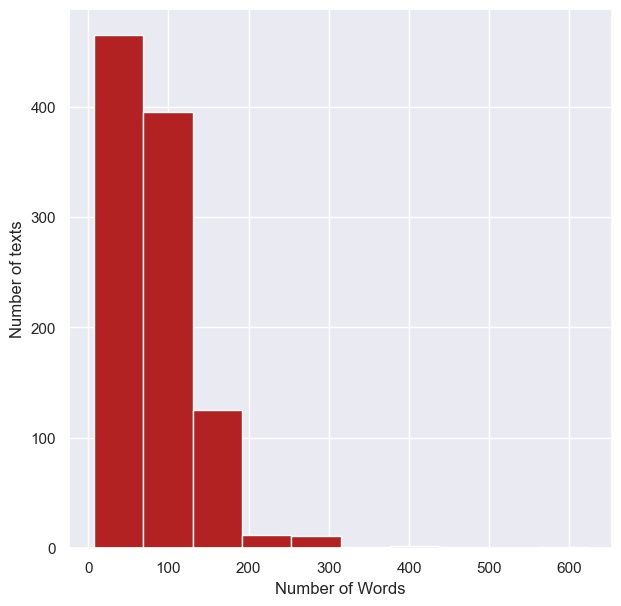

In [104]:
#dibujamos un histograma del número de palabras en la columna "Texto" del conjunto de entrenamiento
seq_len = [len(Texto.split()) for Texto in train_text]

pd.Series(seq_len).hist(bins = 10,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [105]:
#Ejemplo de tokenización con la función nativa de Bert
sample_data = ["El chicharrón es más saludable que algunas verduras.", 
               "Según un nuevo estudio."]                                        
tokenized_sample_data = tokenizer.batch_encode_plus(sample_data,
                                                    padding=True)     
print(tokenized_sample_data)

{'input_ids': [[4, 1162, 24132, 13088, 4569, 1058, 1216, 17181, 1038, 2943, 22577, 1009, 5], [4, 3678, 1049, 1962, 3640, 1009, 5, 1, 1, 1, 1, 1, 1]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]]}


4 y 5 representan especial tokens al comienzo y el fnal de la frase. Y 1 representa el padding

In [106]:
#la mayoría de noticias tienen menos de 120 palabras así que asígnamos MAX_LENGHT = 120
MAX_LENGHT = 120
#tokenizamos y codificamos el train set 
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
#tokenizamos y codificamos el validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
#tokenizamos y codificamos el test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

Este código utiliza el tokenizador BERT para convertir las secuencias de texto en representaciones numéricas (tokens) que pueden ser utilizadas como entrada en un modelo de aprendizaje automático, como por ejemplo un modelo de detección de noticias falsas basado en BERT.

Aquí se utiliza el método batch_encode_plus del tokenizador BERT para tokenizar y codificar por lotes las secuencias de texto en el conjunto de entrenamiento (train_text). Los parámetros importantes son:

max_length: La longitud máxima de las secuencias después de la tokenización.
pad_to_max_length: Rellena las secuencias para que tengan la longitud máxima establecida.
truncation: Trunca las secuencias si exceden la longitud máxima permitida.
El resultado (tokens_train) es un diccionario que contiene las representaciones codificadas de las secuencias de entrenamiento.

In [107]:
#convertimos los tres conjuntos tokenizados (train, val y test) y sus labels en tensores utiliando 
#'inputs_ids' y 'attention_mask'
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [108]:
#definimos la estructura de los data loader
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#El tamaño del lote es la cantidad de ejemplos de entrenamiento que se procesarán en paralelo durante una 
#iteración de entrenamiento.
batch_size = 32                                               

#envolvemos los tensores en un solo conjunto
train_data = TensorDataset(train_seq, train_mask, train_y)    
#creamos un sampler para el conjunto de entrenamiento
train_sampler = RandomSampler(train_data)                     
#construimos el dataloader con el conjunto de datos de entrenamiento, el sampler el tamaño del batch
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

#realizamos la misma operación para el conjunto de validación 
val_data = TensorDataset(val_seq, val_mask, val_y)            
val_sampler = SequentialSampler(val_data)                     
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# 4. Arquitectura de la red neuronal


In [109]:
#Congelamos los parámetros de Beto para que no se reentrenen con los datos nuevos. 
for param in beto.parameters():
    param.requires_grad = False    

In [110]:
#definimos la clase de red neuronal (nn)
class BERT_Arch(nn.Module):
#instanciamos el modelo beto y definimos sus parámetros     
    def __init__(self, beto):  
        super(BERT_Arch, self).__init__()
        self.bert = beto   
        self.dropout = nn.Dropout(0.1)            # capa dropout 
        self.relu =  nn.ReLU()                    # función de activación relu 
        self.fc1 = nn.Linear(768,512)             # capa densa 1
        self.fc2 = nn.Linear(512,2)               # capa densa 2 (capa de salida)
        self.softmax = nn.LogSoftmax(dim=1)       # función de activación softmax (convertir la salida en probabilidad algorítmica)
#instanciamos forward para echar a correr el modelo sobre los datos nuevos  
    def forward(self, sent_id, mask):             
        cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
                                                # pasar los inputs al modelo
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)                           # capa de salida
        x = self.softmax(x)                       # aplicar softmax 
        return x
    
#instaciamos el modelo con el modelo preentrenamo beto
model = BERT_Arch(beto)
#definimos los hiperparámetros (optimizer, weights of the classes and the epochs)
#optimizador y tasa de aprendizaje
from transformers import AdamW
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          
#definimos tasa de pérdida
cross_entropy  = nn.NLLLoss() 
#establécemos el número de épocas de entrenamiento
epochs = 10

# 5. Creación de funciónes de entrenamiento y de evaluación 


In [114]:
#definimos las funciones de entrenamiento y de evaluación 
def train():  
    model.train()
    total_loss, total_accuracy = 0, 0
  
   
    for step,batch in enumerate(train_dataloader):                #itera sobre los lotes
        if step % 50 == 0 and not step == 0:                        
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
        batch = [r for r in batch]                                  
        sent_id, mask, labels = batch 
        model.zero_grad()                                           # limpia los gradientes calculados anteriormente
        preds = model(sent_id, mask)                                # obtiene las predicciones del modelo para el lote actual
        loss = cross_entropy(preds, labels)                         # computa las pérdidas entre los valores reales y sus predicciones
        total_loss = total_loss + loss.item()                       # suma la pérdida total
        loss.backward()                                             # echa hacia atrás para recalcular los gradientes 
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     # transforma los gradientes en 0 y 1 
        optimizer.step()                                            # actualiza los parámetros
        preds=preds.detach().cpu().numpy()                          # manda las predicciones a la cpu

    avg_loss = total_loss / len(train_dataloader)                 # computa la pérdida de entrenamiento por cada época  
                                                                # formate las predicciones como (# samples, # classes)
    return avg_loss                                 # retorna la pérdida y las predicciones

def evaluate():  
    print("\nEvaluating...")  
    model.eval()                                    # Desactiva las capas dropout 
    total_loss, total_accuracy = 0, 0  
    
    for step,batch in enumerate(val_dataloader):    # itera sobre los lotes  
        if step % 50 == 0 and not step == 0:         
                                                  
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
        
                                                  
        batch = [t for t in batch]                    
        sent_id, mask, labels = batch
   
        with torch.no_grad():                         
            preds = model(sent_id, mask)                # predicciones del modelo
            loss = cross_entropy(preds,labels)          # calcula la pérdida del conjunto de validación entre los valores reales y las predicciones
            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
    avg_loss = total_loss / len(val_dataloader)         # computa la pérdida del conjunto de validación por cada época
    return avg_loss

In [123]:
# Entrenamiento y predicción
best_valid_loss = float('inf')
train_losses=[]                   # creamos listas vacías para almacenar las pérdidas de entrenamiento y validación por cada época
valid_losses=[]

for epoch in range(epochs):     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))     
    train_loss = train()                       # entrena el modelo
    valid_loss = evaluate()                    # evalua el modelo
    if valid_loss < best_valid_loss:              # almacena el mejor modelo
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'c2_new_model_weights.pt')
    train_losses.append(train_loss)               # agrega valores de pérdidas a las listas vacías
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10

Evaluating...

Training Loss: 0.437
Validation Loss: 0.392

 Epoch 2 / 10

Evaluating...

Training Loss: 0.419
Validation Loss: 0.373

 Epoch 3 / 10

Evaluating...

Training Loss: 0.404
Validation Loss: 0.355

 Epoch 4 / 10

Evaluating...

Training Loss: 0.391
Validation Loss: 0.340

 Epoch 5 / 10

Evaluating...

Training Loss: 0.372
Validation Loss: 0.327

 Epoch 6 / 10

Evaluating...

Training Loss: 0.365
Validation Loss: 0.315

 Epoch 7 / 10

Evaluating...

Training Loss: 0.347
Validation Loss: 0.303

 Epoch 8 / 10

Evaluating...

Training Loss: 0.335
Validation Loss: 0.289

 Epoch 9 / 10

Evaluating...

Training Loss: 0.319
Validation Loss: 0.279

 Epoch 10 / 10

Evaluating...

Training Loss: 0.315
Validation Loss: 0.270


# 6. Visualización de los resultados

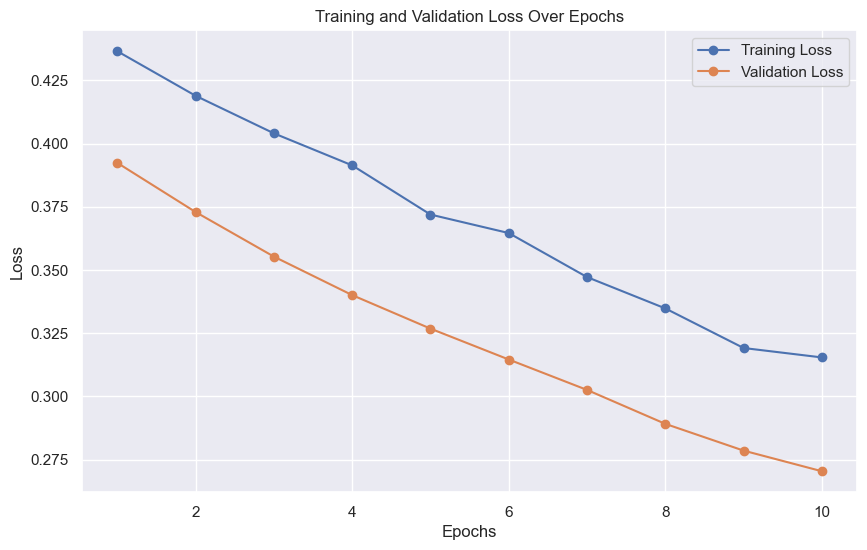

In [130]:
# Visualizamos las pérdidas en los conjuntos de entrenamiento y validación por épocas 
# Crear una figura y ejes
plt.figure(figsize=(10, 6))
epochs_range = range(1, epochs + 1)

# Plotear las curvas de pérdida de entrenamiento y validación
plt.plot(epochs_range, train_losses, label='Training Loss', marker='o')
plt.plot(epochs_range, valid_losses, label='Validation Loss', marker='o')

# Configuramos el  gráfico
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()  # Mostrar la leyenda con etiquetas
plt.show()

La gráfica nos demuestra que la pérdida tanto en el conjunto de entrenamiento como de validación disminuyó en cada una de las épocas. 

# 7. Evaluación del modelo 

In [124]:
#cargamos el archivo que contiene los pesos del mejor modelo
path = 'c2_new_model_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [125]:
#creamos un reporte de clasificación para determinar los scores
with torch.no_grad():
    preds = model(test_seq, test_mask)
    preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.89      0.96      0.93       109
           1       0.96      0.88      0.92       109

    accuracy                           0.92       218
   macro avg       0.92      0.92      0.92       218
weighted avg       0.92      0.92      0.92       218



El reporte de clasificación nos muestra un modelo con unos resultados muy buenos en todas sus métricas. 

Text(54.74999999999999, 0.5, 'Label_Test')

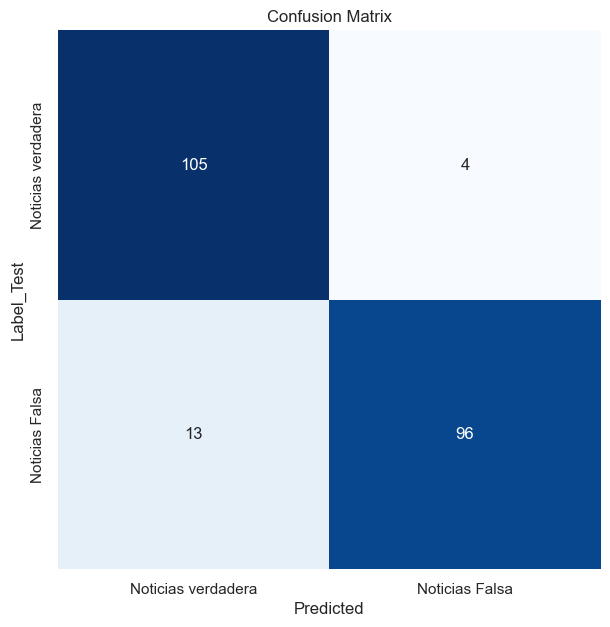

In [126]:
#definimos la matriz de confusión
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias verdadera', 'Noticias Falsa',]
matrix=confusion_matrix(test_y, preds)

#creamos el dataset
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)

#dibujamos el mapa de calor
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues",fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Label_Test")

En la matriz de confusión podemos observar que el modelo predice mucho mejor las noticias verdaderas (solo 4 fallos) que las falsas (13 fallos)

# 8. Evaluación del mejor modelo con noticias nuevas

Utilizamos el mismo conjunto de noticias nuevas para poner a prueba nuestro modelo

In [172]:
#importamos el dataset con las noticias nuevas 
df_detector = pd.read_excel('pruebas_fakenews_detector.xlsx', engine='openpyxl', converters={'Texto': str})
news_list_df = df_detector['texto'].tolist()

In [173]:
df_detector[['titulo','label', 'tipo']]

,titulo,label,tipo
0,Nuevo uniforme de la Policía será reversible,1,sátira
1,Botiquines de vehículos deberán incluir frasco de ayahuasca,1,sátira
2,Ayudenos a pasar esta información! En los próximos días habrá un Domo Atmosférico de Calor,1,evidentemente falsa
3,Fallo de la Corte Suprema de Estados Unidos: Las vacunas contra el Covid NO son vacunas,1,evidentemente falsa
4,Petro reconoce responsabilidad de su Gobierno y el de Duque en pérdida de Panamericanos,0,evidentemente cierta
5,"Capturan a alias Tato y a alias Gordo, dos de los hombres más buscado de Antioquia",0,evidentemente cierta
6,"El chicharrón es más saludable que algunas verduras, según un nuevo estudio",1,salud
7,El director de la OMS pide acabar con el estigma y la discriminación de la lepra,0,salud


In [165]:
#tokenizamos y codificamos el conjunto de noticias nuevas
MAX_LENGHT = 120
tokens_unseen = tokenizer.batch_encode_plus(
    news_list_df,
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

#creamos los tensores
unseen_seq = torch.tensor(tokens_unseen['input_ids'])
unseen_mask = torch.tensor(tokens_unseen['attention_mask'])

In [166]:
#1, 1, 1, 1, 1, 0, 0, 1, 0

#realizamos las predicciones
with torch.no_grad():
    preds = model(unseen_seq, unseen_mask)
    preds = preds.detach().cpu().numpy()

#imprimimos como un array de 0 y 1 
preds = np.argmax(preds, axis = 1)
preds

array([0, 0, 1, 1, 0, 0, 0, 0])

Análisis de los resultados ver 'Conclusiones'

In [168]:
#evaluamos pero obtenemos como resultado un conjunto de probabilidades 

with torch.no_grad():
    preds = model(unseen_seq, unseen_mask)
    probs = F.softmax(preds, dim=1)
    probs = probs.detach().cpu().numpy()

#iteramos para obtener la probabilidad de que sea una noticia falsa
for i, prob in enumerate(probs):
    probability_fake = prob[1]
    print(f"La noticia {i} tiene una probabilidad del {probability_fake:.2%} de ser falsa.")

La noticia 0 tiene una probabilidad del 48.09% de ser falsa.
La noticia 1 tiene una probabilidad del 46.64% de ser falsa.
La noticia 2 tiene una probabilidad del 81.29% de ser falsa.
La noticia 3 tiene una probabilidad del 57.17% de ser falsa.
La noticia 4 tiene una probabilidad del 7.26% de ser falsa.
La noticia 5 tiene una probabilidad del 6.84% de ser falsa.
La noticia 6 tiene una probabilidad del 39.48% de ser falsa.
La noticia 7 tiene una probabilidad del 45.35% de ser falsa.


Análisis de los resultados ver 'Conclusiones'

In [156]:
#codifico para poder evaluar el texto de solo una noticia

class News:
    def __init__(self, text):
        self.text = text

# Crear instancias de la clase News para cada noticia
news1 = News('noticia falsa')

news_list = [news1.text] 


# tokenize and encode sequences in the test set
MAX_LENGHT = 120
tokens_unseen = tokenizer.batch_encode_plus(
    news_list,
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

unseen_seq = torch.tensor(tokens_unseen['input_ids'])
unseen_mask = torch.tensor(tokens_unseen['attention_mask'])


with torch.no_grad():
    preds = model(unseen_seq, unseen_mask)
    probs = F.softmax(preds, dim=1)
    probs = probs.detach().cpu().numpy()

# Ahora 'probs' contiene las puntuaciones de probabilidad para cada clase
for i, prob in enumerate(probs):
    # Obtener la probabilidad de la clase 1
    probability_fake = prob[1]
    
    # Imprimir el resultado de manera legible
    print(f"La noticia {i + 1} tiene una probabilidad del {probability_fake:.2%} de ser falsa.")

La noticia 1 tiene una probabilidad del 93.12% de ser falsa.


# 9. Conclusiones

En los resultados de 0/1 podemos observar que: 
- El modelo acierta al clasificar las noticias que son evidentemente falsas y las que son evidentemente ciertas (noticias 2 y 3 y noticias 4 y 5)
- Las noticias sátiricas (0 y 1) las clasifica como verdaderas
- La noticia del chicharrón la clasifica como verdadera siendo falsa
- La noticia sobre la OMS la clasifica correctamente como verdadera

Los resultados con probabilidades nos dan más información sobre la clasificación: 
- Las noticias sátiricas las clasifica como verdaderas pero en los dos casos está muy cerca de clasificarlas como falsas. Podría decir que estas noticias cumplen su papel de confundir al modelo de predicción. 
- Las noticias que son evidentemente falsas tienen un porcentaje muy alto de ser falsas (especialmente la noticia 2) 
- Las noticias verdaderas (4 y 5) tienen una probabilidad muy alta de ser verdaderas. 
- La noticia del chicharrón, aunque la califica como verdadera en este modelo tiene más probabilidad de ser falsa (39.48%) que con el modelo de ML (34.27%). 
- La noticia 7 que es verdadera en este modelo tiene mayor probabilidad de ser falsa (45.35%) que en el modelo ML (17.95%)

Sin embargo, con BERT podemos establecer unos criterios claros de clasificación: 
- Clasifica muy bien las noticias evidentemente falsas y las noticias evidentemente verdaderas. 
- Las noticias satíricas las califica como verdaderas, pero con una probabilidad alta de ser falsas. 
- Las noticias sobre salud (la del chicharrón y la de la OMS) las califica como ciertas, pero también tienen una probabilidad alta de ser falsas. 

# Nota 

Este trabajo está basado en los siguientes tutoriales: 
 
Basic intuition behind Transfer Learning
https://www.youtube.com/watch?v=G8mYqxajvFk&t=0s

Deep-dive into Google’s BERT Model for NLP
https://www.youtube.com/watch?v=mn1dEpvEkX8&t=0s

Fake News Detection Project with BERT Fine-tuning
https://www.youtube.com/watch?v=LbYF0yMIFaM&t=669s
    
Modelo implementado en: 
https://colab.research.google.com/drive/1JT0G0L2xYx_CGQ0d8h1SFuA5yOlJLeYf#scrollTo=LGFpP494zgLh